## Modeling Uncertainty in Random Forests and Neural Networks

This notebook produces scikit-garden and TFP predicitons for LAI and fAPAR for the NAIVE database for each biome and, using the validation datasets, compares the predicted confidence intervals to:
1. Epistemic error (Cross validation error)
2. Aleatoric error (The standard deviation of LAI and fAPAR given in the algorithm)

## Inital Setup

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import modules
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [9]:
# List of biome numbers
biomes = [1,2,3,4,5,6,7,8]

In [10]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('C:/Users/casli/cassidy/data/py37/valbiomeDictLAI.pkl')
# https://drive.google.com/drive/folders/17pL6zsZqGIPmJt5ChS_wxqVuZHdZa4Lg?usp=sharing

In [66]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF'].sample(10000)
    dfval = valbiomeDictLAI[i]['DF'].sample(1000)

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]

    valbiomeDictLAI[i]['X_test'] = dfval[regressors]
    valbiomeDictLAI[i]['y_test'] = dfval[response]

## Random Forest

### Random Forest Regression

In [ ]:
# Creating and fitting a Random Forest Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rf'] = valbiomeDictLAI[i]['rf'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

In [ ]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    valbiomeDictLAI[i]['DF']['y_rf'] = valbiomeDictLAI[i]['rf'].predict(valbiomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['y_rf'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

### Quantile Regression

In [ ]:
%%html
<style>
table {float:left}
</style>

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [ ]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

In [ ]:
# Creating a Random Forest Quantile Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [ ]:
print(valbiomeDictLAI[1]['rfqr'])

In [ ]:
# Fitting a Random Forest Quantile Regressor for each biome type
for i in biomes:
    valbiomeDictLAI[i]['rfqr'].set_params(max_features=calbiomeDictLAI[i]['X_train'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

In [ ]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['DF']['upper'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

In [ ]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['upper'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['lower'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Comparing Random Forest and Quantile Forest

In [ ]:
axes=[]
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['DF']['y_rf'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
    
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Neural Network

### TensorFlow

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

### Aleatoric Uncertainty

In [21]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [22]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['nn'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(80, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])

In [23]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['nn'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(tfpl.IndependentNormal.params_size(80)),
        tfpl.IndependentNormal(event_shape=80),
        layers.Dense(tfpl.IndependentNormal.params_size(25)),
        tfpl.IndependentNormal(event_shape=25),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])

In [24]:
for i in biomes:
    valbiomeDictLAI[i]['nn'].compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=negloglik,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [26]:
for i in [1]:
    callbacks = myCallback()
    valbiomeDictLAI[i]['nn_history'] = valbiomeDictLAI[i]['nn'].fit(calbiomeDictLAI[i]['X_train'].to_numpy(), calbiomeDictLAI[i]['y_train'].to_numpy(), epochs=50, validation_split=0.2, verbose=1, callbacks=[callbacks])

Epoch 1/50
250/250 [==============================] - 4s 8ms/step - loss: 258.2831 - root_mean_squared_error: 15.5130 - val_loss: 5.2603 - val_root_mean_squared_error: 15.9000
Epoch 2/50
250/250 [==============================] - 1s 5ms/step - loss: 5.5513 - root_mean_squared_error: 16.4454 - val_loss: 4.4797 - val_root_mean_squared_error: 16.5218
Epoch 3/50
250/250 [==============================] - 1s 5ms/step - loss: 4.3523 - root_mean_squared_error: 16.7081 - val_loss: 4.7833 - val_root_mean_squared_error: 16.4231
Epoch 4/50
250/250 [==============================] - 1s 5ms/step - loss: 4.2214 - root_mean_squared_error: 16.4976 - val_loss: 4.0285 - val_root_mean_squared_error: 16.6933
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 4.0511 - root_mean_squared_error: 16.5376 - val_loss: 4.0014 - val_root_mean_squared_error: 16.1608
Epoch 6/50
 33/250 [==>...........................] - ETA: 1s - loss: 3.9607 - root_mean_squared_error: 16.2568

KeyboardInterrupt: 

In [ ]:
valbiomeDictLAI[i]['DF']['y_nn'] = valbiomeDictLAI[i]['nn'].predict(valbiomeDictLAI[i]['X_test'])

In [ ]:
y_mean = valbiomeDictLAI[i]['nn'](valbiomeDictLAI[i]['X_test'].to_numpy()).mean()
y_sd = valbiomeDictLAI[i]['nn'](valbiomeDictLAI[i]['X_test'].to_numpy()).stddev()

y_hat_lower = y_mean - 2 * y_sd
y_hat_upper = y_mean + 2 * y_sd

In [ ]:
print(y_sd)
print(y_mean)

In [ ]:
axes = []
for i in [1]:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], y_sd, s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [ ]:
sklearn.metrics.mean_squared_error(valbiomeDictLAI[1]['y_test'], valbiomeDictLAI[1]['DF']['y_nn'], squared=False)

In [ ]:
valbiomeDictLAI[2]['nn'].summary()

### Epistemic Uncertainty

#### Sources
Probabilistic regression with Tensorflow: https://ekamperi.github.io/machine%20learning/2021/01/07/probabilistic-regression-with-tensorflow.html

#### Background Information
**Epistemic uncertainty** or model uncertainty is related to our knowledge regarding the data generating process. For example, the uncertainty regarding which parameters accurately model the experimental data. 

Epistemic uncertainty can be decreased by adding more training data. Its modeling is realized by enabling a neural network's wieghts to be probabilistic rather than deterministic,

#### Prior Distribution
Defining a prior distribution for model's weights. Adopting a normal distribution as a prior is a good way to initalize a probabilistic neural network. As the **central limit theorem** assets, a properly normalized sum of samples will approximate a nromal distribution no matter the actual underlying distribution.

We used `MultivariateNormalDiag()` (a multivariate normal distribution wtih a diagonal covariance matrix), with zero mean (`loc=tf.zeros(n)`) and a standard deviation of 1 (`scale_diag=tf.ones(n)`). The we use the `DistrubtionLambda()` function to transform the distribution object into a Keras-compatible layer, and inject it into a `keras.Sequantial()` model. 

In [47]:
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

#### Posterior Distribution
Unlike the prior distribution, we want the posterior to be trainable. We will use a multivariate Gaussian distribution, but allows off-diagonal elements in the covariance matrix to be non-zero. 
There are 3 ways to parameterize such a distribution:
1. in terms of a positive definite covariance matrix
2. via a positive definite precision matrix
3. with a lower-triangular matrix with positive-valued diagonal entries (can be obtained via **Cholesky decomposition**)

In this case, we use method 3 with `MultivariateNromalTriL()` (*TriL* stands for *triangular lower*). We will use `VariableLayer()` that generates a trainable variable to parametrize `MultivariateNromalTriL()`, using `.params_size()` to get a precise number of parameters necessary.

In [48]:
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

#### Defining the model
We define the probabilistic layers in a neural network using the `DenseVariational()` function, specifying input/output shape, with prior and posterior distributions previously defined. Note that the prior and posterior functions should be passed as objects without actually calling them. 

The last 2 parameters specified in the variational layer are related to **Kullback_Leibler divergence** (KL divergence). Because this term is coputed on a different subset of data than the second term in ELBO, we need to rescale it so that it's unbiased. `kl_use_exact()` controls if we want to compute KL divergence analytically or use and empirical approximation (default is `False`: empirical approximation).

This layer implements *Bayes by backprop*, an approximate method that can be used for efficient weight uncertainty estimation in neural networks. It returns a point estimate of the output, but its weights (and biases) are probabilistic.

Use a **relu** activation function to enable the network model non-linear data.


**Ignore for now**
Use `IndependentNormal()` output layer to caputre aleatoric uncertainty, with event shape equal to 1 for a single output.

In [76]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the Adam optimizer
normalizer = layers.Normalization(input_shape=[5,], axis=None)
normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))

model = tf.keras.Sequential([
    normalizer,
    tfpl.DenseVariational(input_shape=[5,], units=80,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=25,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
                          kl_use_exact=False,
                          activation='relu'),
    tfpl.DenseVariational(units=1,
                          make_prior_fn=get_prior,
                          make_posterior_fn=get_posterior,
                          kl_weight=1/calbiomeDictLAI[1]['X_train'].shape[0],
                          kl_use_exact=False)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_23 (Normaliza  (None, 5)                3         
 tion)                                                           
                                                                 
 dense_variational_41 (Dense  (None, 80)               115920    
 Variational)                                                    
                                                                 
 dense_variational_42 (Dense  (None, 25)               2053350   
 Variational)                                                    
                                                                 
 dense_variational_43 (Dense  (None, 1)                377       
 Variational)                                                    
                                                                 
Total params: 2,169,650
Trainable params: 2,169,647
N

#### Train the Model
Train the model for 50 epochs and plot the loss function to confirm that the algorithm as converged.

In [ ]:
# Train the model for 50 epochs
history = model.fit(calbiomeDictLAI[1]['X_train'].to_numpy(), calbiomeDictLAI[1]['y_train'].to_numpy(), epochs=50, verbose=1)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

Epoch 1/50
242/313 [======================>.......] - ETA: 12s - loss: 2254400.2500 - root_mean_squared_error: 1501.4653

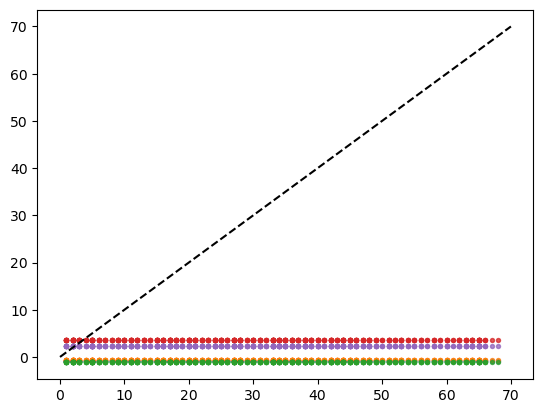

In [75]:
for i in range(5):
    y_model = model(valbiomeDictLAI[1]['X_test'])
    plt.scatter(valbiomeDictLAI[1]['y_test'], y_model, alpha=0.5, s=8)
plt.plot([0, 70], [0, 70], 'k--')

## Questions
1. Which predictor is better in general in terms of RMSE  and bias overall and for unsaturated and saturated validation samples.
2. What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)
3. What is the relative size of the standard deviation of LAI or fAPAR absolute residual to the prediction confidence interval
4. Does the prediction confidence interval change as the sample size decreases?

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_100'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper'] - valbiomeDictLAI[biome]['DF']['lower'],
            'sample_size': 100,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_100'] = pd.concat([valbiomeDictLAI[biome]['result_df'], df])

### Question 1
Which predictor is better in general in terms of RMSE and bias overall and for unsaturated and saturated validation samples. 

In [ ]:
# kde plots of both methods on the same graph showing predicted versus actual
fig, ax = plt.subplots()
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='y_pred', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')
plt.xlim([-10, 80])
plt.ylim([-10, 80])

In [ ]:
# Scatter plots (with 1000 samples only) of each estimated versus predicted together with confidence intervals indicated using symbols rather than bars


### Question 2
What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='residual', hue='predictor')
plt.plot([0, 80], [0, 0], 'k--')

### Question 3
What is the relative size of the standard deviation of LAI or fAPAR  absolute residual to the  prediction confidence interval

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df_100'], x='y_true', y='stddev', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')

### Question 4
Does the prediction confidence interval change as the sample size decreases?  

In [ ]:
# Sample 50% of the calibration data
for i in biomes:
    calbiomeDictLAI[i]['X_train_50'] = calbiomeDictLAI[i]['X_train'].sample(frac=0.5)
    calbiomeDictLAI[i]['y_train_50'] = calbiomeDictLAI[i]['y_train'].sample(frac=0.5)

In [ ]:
# Create and fit a Random Forest Quantile Regressor using 50% of the calibration samples
for i in biomes:
    valbiomeDictLAI[i]['rfqr_50'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rfqr_50'].set_params(max_features=calbiomeDictLAI[i]['X_train_50'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr_50'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train_50'], calbiomeDictLAI[i]['y_train_50'])

In [ ]:
# Predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['DF']['upper_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid_50'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

In [ ]:
# Create and fit a Neural Network using 50% of the calibration samples

In [ ]:
# Predicting a Neural Network for each biome type with 95% prediction confidence interval

In [ ]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df_50'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            'rmse': metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_' + predictor], squared=False),
            'residual': valbiomeDictLAI[biome]['DF']['y_' + predictor] - valbiomeDictLAI[biome]['y_test'],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'pi_mag': valbiomeDictLAI[biome]['DF']['upper_50'] - valbiomeDictLAI[biome]['DF']['lower_50'],
            'sample_size': 50,
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df_50'] = pd.concat([valbiomeDictLAI[biome]['result_df_50'], df])

In [ ]:
# Plot the prediction confidence intervals magnitude versus the true value (maybe a kde plot) for 100% and 50%
data = pd.concat([valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], valbiomeDictLAI[biome]['result_df_100'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf']])
sns.kdeplot(data=data, x='y_true', y='pi_mag', hue='sample_size')

In [ ]:
sns.scatterplot(data=valbiomeDictLAI[biome]['result_df_50'].loc[valbiomeDictLAI[biome]['result_df_50']['predictor'] == 'rf'], x='y_true', y='pi_mag')